# Wisconsin Employment 1961-1975

In this notebook we carry the study of the Wisconsin employment 1961-1975 time series with Long Short-Term Memory Networks. 

## Table of contents:

1. [Introduction](#introduction)
2. [Imports](#imports)
3. [Time Series Visualization](#visualization)
4. [Preprocessing of the time series](#preprocess)
5. [Find an optimal model](#opti)
6. [Two years forecasts](#two_year)
7. [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

Traditional neural networks take as input a standalone vector of data. They have no concept of time nor memory. Thus they can not be used to deal with times series. 

A first attempt to tackle this issue was to give feedback to neurons on their activations at previous time steps. These are called Recurrent Neural Networks. However they had an important flaw known as the Vanishing Gradient Problem. It made it hard to learn long-term dependencies of sequence data with RNNs. Then came Long Short Term Memory Neural Networks or LSTM for short. They were invented by Sepp Hochreiter and Jurgen Schmidhuber ${[4]}$. They also introduced the concept of memory thanks to explicit memory units and thus could deal with sequential problems. Furthermore, they did not present the problem of Vanishing Gradient.

LSTM networks are RNN with memory units instead of standard neurons. We will not go into theoretical details as it would take us too far. ${[4]}$ presents a detailed and mathematical approach to LSTM. 

We display a single LSTM memory unit ${[5]}$.

<img src="lstm_unit.png">

Four structures exist in the unit:

In the red box is the core of the memory unit, it is the internal state of the memory. It keeps its value from one time step to the next. It will write in memory when it is useful for the task. The term ‘useful’ is rather vague but the update is conditioned on other values of the LSTM unit.

In the orange box lies the input gate. This gate will decide when to write in the input information in the memory unit. The act of deciding depends on the value of learnable parameters in the input gate. 

In the yellow box lies the forget gate. As its name tells us this gate learns when the memory should be forgotten. 

Lastly, in pink is the output gate. It controls the extent to which the value in the cell is used to compute the output activation of the LSTM cell. 

## 2. Imports<a name="imports"></a>

### 2.1 Packages

In [1]:
import os
import math
import keras
import random
import sklearn
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Sequential
from keras.layers import RepeatVector, TimeDistributed, Dense, Dropout
from keras.layers import LSTM, Conv1D, Bidirectional, MaxPooling1D, Flatten

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [2]:
# Routine to be sure to get reproductible results
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### 2.2 Load and format the time series
We start by loading the time series and define the index to be the months.

In [3]:
# Load the dataset
df = pd.read_csv('Data/wisconsin-employment-time-series.csv', header=0, squeeze=True, infer_datetime_format=True)
df = df.rename(columns={'Data': 'Employment figures'})
df['Month'] = pd.DatetimeIndex(df['Month'])
# Set 'Month' to be the index
df = df.set_index('Month')

## 3. Time Series Visualizations <a name="visualization"></a>
Before doing any analysis or predictions on the dataset, we visualize the time series and its decomposition into trend and seasonality. The decomposition can be easily done using the __seasonal_decompose__ function from the __statsmodels__ library. The red dashed line represents the train-test separation.

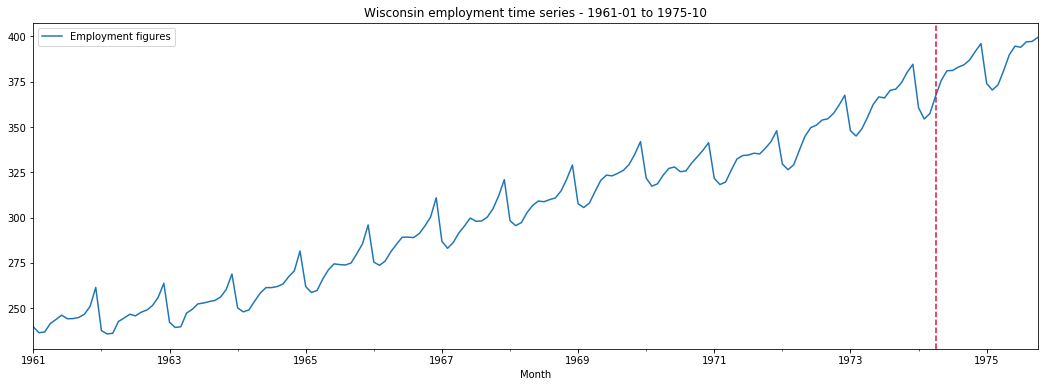

In [4]:
# Plot the time series
df.plot(colormap='tab10')
plt.title('Wisconsin employment time series - 1961-01 to 1975-10')
plt.axvline(x='1974-04', linestyle='--', c='crimson')
plt.gcf().set_size_inches(18,6)
plt.show()

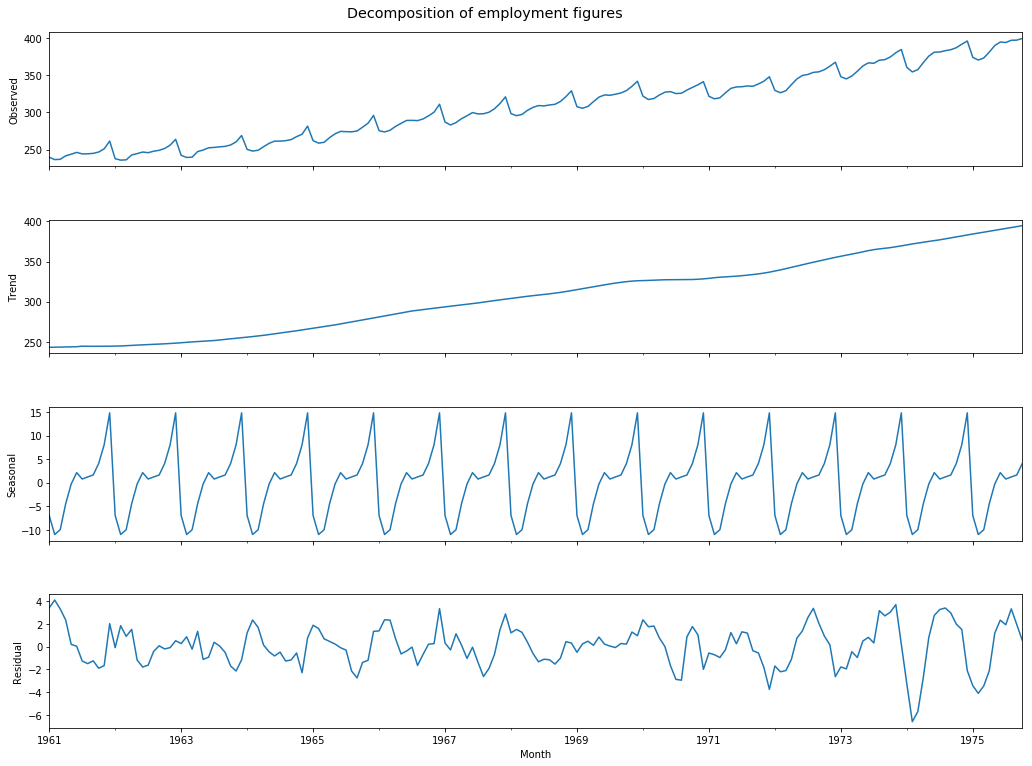

In [5]:
# Decompose time series
decomposition = seasonal_decompose(df, model='additive', extrapolate_trend='freq')

# Plot the decomposition
decomposition.plot()
plt.suptitle('Decomposition of employment figures', size='x-large')
plt.subplots_adjust(top=0.95)
plt.gcf().set_size_inches(16,12)
plt.show()

## 4. Preprocessing of the time series<a name="preprocess"></a>
The preprocessing of the time series is quite easy since we only rescale the values and extract some of them as validation data.

### 3.1 Scaling
Since LSTMs are sensitive to the scale of the input data, it is a good practice to rescale the data to the range zero to unity, this is the normalizing step. We do it using the __MinMaxScaler__ function from the __scikit-learn__ library ${[1]}$.

In [6]:
# Scale the values using MinMaxScaler
obs = df['Employment figures'].values
obs = obs.reshape(len(obs), 1)
mm_scaler = MinMaxScaler().fit(obs)
obs_scale = mm_scaler.transform(obs).flatten()

### 3.2 Hide the end of the time series

We hide the last 18 months of the time series in order to use it as a validation test and measure the accuracy of the models using four different metrics score.

In [7]:
obs_train = obs_scale[:obs_scale.shape[0]-18]
obs_test = obs_scale[obs_scale.shape[0]-18:]

## 5. Find an optimal model<a name="opti"></a>
Given the validation set that we created above, we will test four different LSTM architectures and for each of them we will implement two different approaches, one static and one dynamic. Thereafter we will compare their accuracy using four different metrics.

In [8]:
def split_sequence(sequence, window):
    """ This function splits the time series into a sequence of n_steps values
        used to predict the n_steps + 1 value. This transform the time series
        to a supervised learning problem. """
    # Initialize X and y
    X, y = [], []
    for i in range(len(sequence)):
        # Define the end of the observations
        end = i + window
        # Check for IndexOutOfBounds
        if end > len(sequence)-1:
            break
        # Add the observations sequence and the prediction
        X.append(sequence[i:end])
        y.append(sequence[end])
    # Return X and y
    return np.array(X), np.array(y)

In [9]:
def get_predictions_static(model, obs_train, window, n_predictions, n_epochs, CNN=False):
    """ This function computes the predictions using a model that is trained only
        once on all known values. """
    # Get the observations and the targets
    X_train, y_train = split_sequence(obs_train, window)
    # Reshape to fit the model's input shape
    if(CNN):
        X_train = X_train.reshape((X_train.shape[0], 2, int(window/2), 1))      
    else:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    # Train the model on all known observations
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0)
    # Copy obs_train to append the predictions
    obs_train_ = obs_train.copy()
    for i in range(n_predictions):
        # Get the window-last observations
        X_pred = obs_train_[obs_train_.shape[0]-window:]
        # Reshape to fit the model's input shape
        if(CNN):
            X_pred = X_pred.reshape((1, 2, int(window/2), 1))
        else:
            X_pred = X_pred.reshape((1, len(X_pred), 1))
        # Get the prediction
        y_pred = model.predict(X_pred)
        # Store the prediction to use it as observation in the next step
        obs_train_ = np.append(obs_train_, y_pred)
    return obs_train_

In [10]:
def get_predictions_dynamic(model, obs_train, window, n_predictions, n_epochs, CNN=False):
    """ This function computes the predictions using a model that is trained at
        each time a new prediction gets available."""
    # Copy obs_train to append the predictions
    obs_train_ = obs_train.copy()
    for i in range(n_predictions):
        # Get the observations and the targets
        X_train, y_train = split_sequence(obs_train_, window)
        # Reshape to fit the model's input shape
        if(CNN):
            X_train = X_train.reshape((X_train.shape[0], 2, int(window/2), 1))      
        else:
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        # Train the model on all known observations
        model.fit(X_train, y_train, epochs=n_epochs, verbose=0)
        # Get the window-last observations
        X_pred = obs_train_[obs_train_.shape[0]-window:]
        # Reshape to fit the model's input shape
        if(CNN):
            X_pred = X_pred.reshape((1, 2, int(window/2), 1))
        else:
            X_pred = X_pred.reshape((1, len(X_pred), 1))
        # Get the prediction
        y_pred = model.predict(X_pred)
        # Store the prediction to use it as observation in the next step
        obs_train_ = np.append(obs_train_, y_pred)
    return obs_train_

In [11]:
# We will use a window of size 50
window = 50
# Define the number of epochs
n_epochs = 200

### 5.1 Architectures definition
We start by defining the four LSTM architectures:
- Vanilla LSTM
- Stacked LSTM
- Bidirectionnal LSTM
- CNN LSTM

The following architectures have been implemented using the help of ${[2]}$ on LSTM development for Time Series.

#### 5.1.1 Vanilla LSTM Architecture
The Vanilla LSTM is the most basic LSTM architecture. It has a single hidden layer of LSTM units, and an output layer used to make a prediction. We use 50 LSTM units matching a window of size 50 (input sequences will consist of 50 consecutive observations). The network will output a single numerical value. We look at it as being the value that follows the sequence we used as input.

In [12]:
# Vanilla LSTM
van_model = Sequential()
van_model.add(LSTM(50, activation='relu', input_shape=(window, 1)))
van_model.add(Dense(1))
van_model.compile(optimizer='adam', loss='mse')
van_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#### 5.1.2 Stacked LSTM Architecture
A stacked LSTM architecture is such that many hidden layers can be stacked one on top of another. Here we choose to stack two layers of 50 LSTM units. As previously we have a single numerical output. 

In [13]:
# Stacked LSTM
st_model = Sequential()
st_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(window, 1)))
st_model.add(LSTM(50, activation='relu'))
st_model.add(Dense(1))
st_model.compile(optimizer='adam', loss='mse')
st_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


#### 5.1.3 Bidirectional LSTM Architecture
In Bidirectional LSTM architectures, we train two instead of one LSTM networks on the input sequence. The first on the original input sequence and the second on a reversed copy of the input sequence. To do this we wrap the LSTM layer in a layer called Bidirectional. 

In [14]:
# Bidirectional LSTM
bi_model = Sequential()
bi_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(window, 1)))
bi_model.add(Dense(1))
bi_model.compile(optimizer='adam', loss='mse')
bi_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


#### 5.1.4 CNN LSTM Architecture
The CNN LSTM architecture involves using a one dimensional Convolutional Neural Network (CNN) layer for feature extraction on input data combined with LSTM units to support sequence prediction. Max Pooling is also performed to reduce the dimensionality of the convolution.

In [15]:
# CNN LSTM
cnn_model = Sequential()
cnn_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                              input_shape=(None, int(window/2), 1)))
cnn_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_model.add(TimeDistributed(Flatten()))
cnn_model.add(LSTM(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 25, 64)      128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 12, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 768)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                163800    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 163,979
Trainable params: 163,979
Non-trainable params: 0
_________________________________________________________________


In [16]:
models = [van_model, st_model, bi_model, cnn_model]

### 5.2 Test the models - Static approach
In this static approach we use the following scheme. We train the model once on the known values and we propagate the 50 most recent known values through the network to get the first prediction. Once we have this first prediction, it becomes a known value that we will use to compute the next prediction. Therefore, at the second iterative step, the input will consist of the 49 most recent initially known values plus the first prediction. And we keep going on like this until we have predicted all the missing values.

In [17]:
# Define the parameters
n_predictions = 18
col_name = ['Vanilla static preds', 'Stacked static preds', 'Bidirectional static preds', 'CNN static preds']

In [18]:
# For each model, get the predictions and store them
for i, model in enumerate(models):
    y_pred = get_predictions_static(model, obs_train, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df[col_name[i]] = y_pred_unscale

Instructions for updating:
Use tf.cast instead.


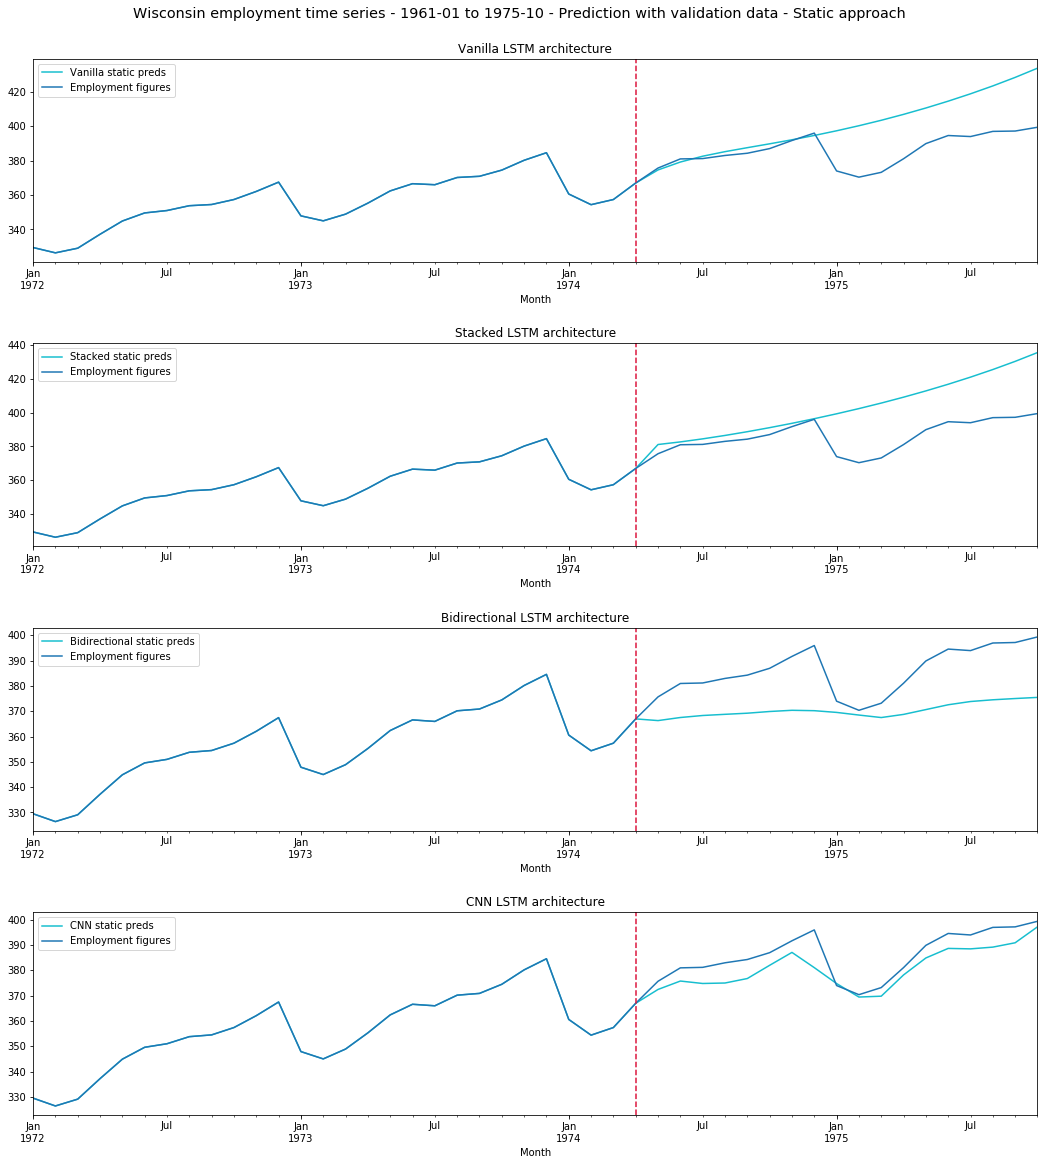

In [19]:
# Plot the result
sub_titles = ['Vanilla LSTM architecture', 'Stacked LSTM architecture',
              'Bidirectional LSTM architecture', 'CNN LSTM architecture']
title = 'Wisconsin employment time series - 1961-01 to 1975-10 - Prediction with validation data - Static approach'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df[[col_name[i], 'Employment figures']]['1972-01':].plot(ax=ax[i], colormap='tab10_r')
    ax[i].title.set_text(sub_titles[i])
    ax[i].axvline(x='1974-04', linestyle='--', c='crimson')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.94)
plt.gcf().set_size_inches(18, 18)
plt.show()

### 5.3 Test the models - Dynamic approach
In the dynamic approach, instead of training the model only once at the begining with the known values, we perform a training iteration each time we have computed a new prediction. Hence, we predict the 18 missing values with 18 different models.

In [20]:
# Define the parameters
n_predictions = 18
col_name = ['Vanilla dynamic preds', 'Stacked dynamic preds', 'Bidirectional dynamic preds', 'CNN dynamic preds']

In [21]:
# For each model, get the predictions and store them
for i, model in enumerate(models):
    y_pred = get_predictions_dynamic(model, obs_train, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df[col_name[i]] = y_pred_unscale

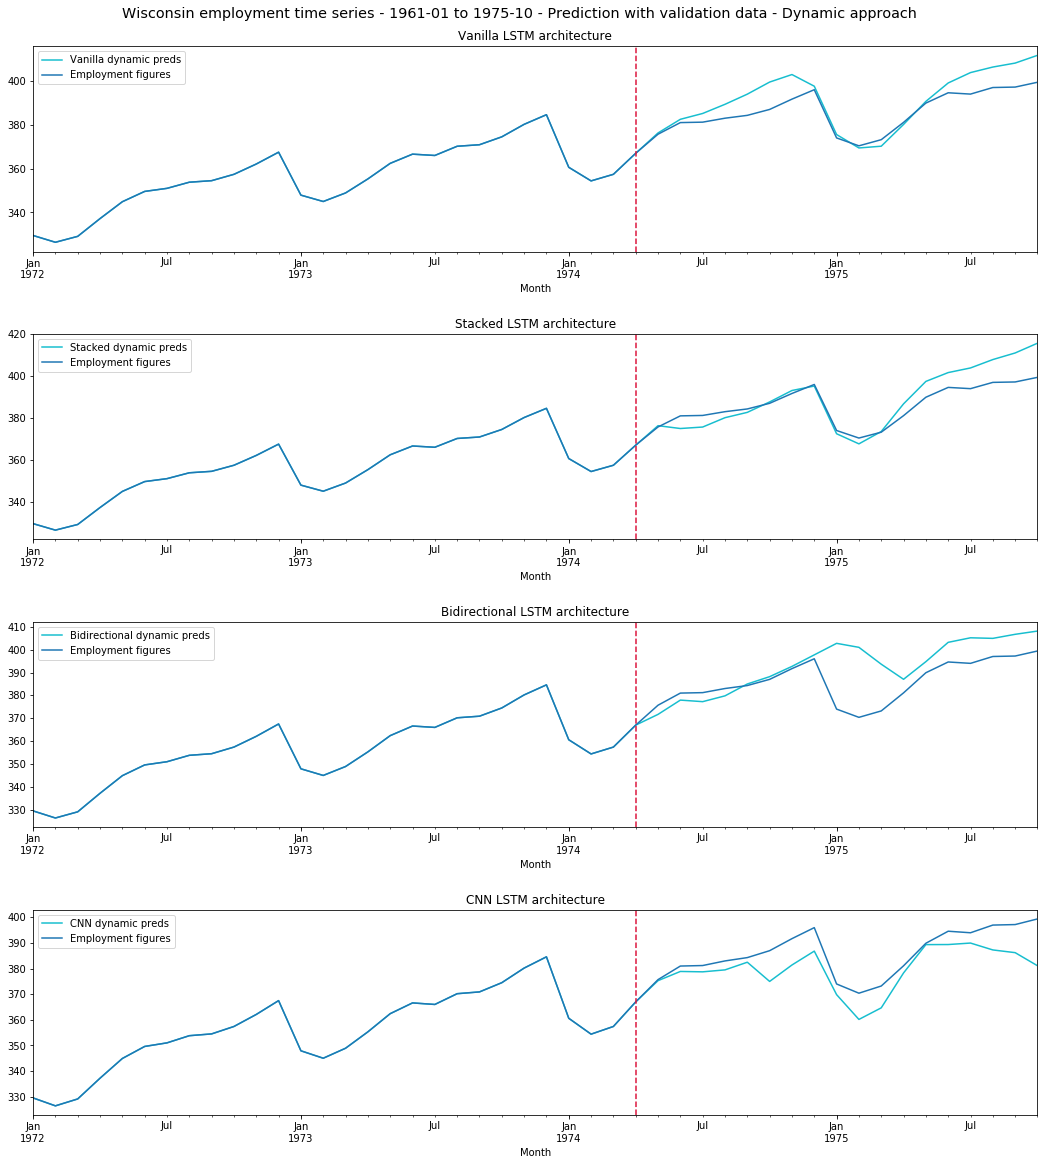

In [22]:
# Plot the result
sub_titles = ['Vanilla LSTM architecture', 'Stacked LSTM architecture',
              'Bidirectional LSTM architecture', 'CNN LSTM architecture']
title = 'Wisconsin employment time series - 1961-01 to 1975-10 - Prediction with validation data - Dynamic approach'
fig, ax = plt.subplots(nrows=len(models))
for i in range(len(models)):
    df[[col_name[i], 'Employment figures']]['1972-01':].plot(ax=ax[i], colormap='tab10_r')
    ax[i].title.set_text(sub_titles[i])
    ax[i].axvline(x='1974-04', linestyle='--', c='crimson')
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.4, top=0.95)
plt.gcf().set_size_inches(18, 18)
plt.show()

### 5.4 Compare the accuracy metrics
Let's compare the models using four different accuracy metrics ${[3]}$:
- The Mean Forecast Error (or Forecast Bias)
- The Mean Absolute Error
- The Mean Squared Error
- The Root Mean Squared Error

In [23]:
def get_pred_metrics(df, y_test, columns):
    """ Given a dataframe with predicted values, the columns' name of the
        predicted values and the validation test, this function computes 4
        different metrics, MFE, MAE, MSE and RMSE. """
    mfes, maes, mses, rmses = [], [], [], []
    for col in columns:
        mfes.append(np.mean(y_test - df[col]))
        maes.append(mean_absolute_error(y_test, df[col]))
        mses.append(mean_squared_error(y_test, df[col]))
        rmses.append(np.sqrt(mean_squared_error(y_test, df[col])))
    return mfes, maes, mses, rmses

In [24]:
# Define the initial values
y_test = df['Employment figures']
# Get the metrics for the static models
columns_static = df.columns.values[1:5]
mfes_static, maes_static, mses_static, rmses_static = get_pred_metrics(df, y_test, columns_static)
# Get the metrics for the dynamic models
columns_dynamic = df.columns.values[5:9]
mfes_dynamic, maes_dynamic, mses_dynamic, rmses_dynamic = get_pred_metrics(df, y_test, columns_dynamic)

In [25]:
# Construct a dataframe to show the result
metrics = {'Static MFE': mfes_static,
           'Static MAE': maes_static,
           'Static MSE': mses_static,
           'Static RMSE': rmses_static,
           'Dynamic MFE': mfes_dynamic,
           'Dynamic MAE': maes_dynamic,
           'Dynamic MSE': mses_dynamic,
           'Dynamic RMSE': rmses_dynamic}
index = ['Vanilla', 'Stacked', 'Bidirectional', 'CNN']
df_comp = pd.DataFrame(metrics)
df_comp.index = index
df_comp

,Static MFE,Static MAE,Static MSE,Static RMSE,Dynamic MFE,Dynamic MAE,Dynamic MSE,Dynamic RMSE
Vanilla,-1.530659,1.578895,41.259348,6.423344,-0.514743,0.569721,5.192404,2.278685
Stacked,-1.750850,1.750850,47.862566,6.918278,-0.298296,0.536009,5.089291,2.255946
Bidirectional,1.591102,1.591102,29.790117,5.458032,-0.712234,0.871977,15.299981,3.911519
CNN,0.527853,0.536806,3.841641,1.960010,0.652728,0.652728,6.490163,2.547580


In the Static approach, CNN is the best performing architecture while in the Dynamic one the Stacked architecture comes out on top.

## 6. Two years dynamic forecasts <a name="two_year"></a>
Now that we have tested our models with validation data, we forecast the employment figures over the next two years, i.e. 24 values - one per month. We use the same input as before. A window of size 50 predicts the new value and once we have a new prediction we add it to the known values and move the window forward.

In [26]:
# Use a copy of the original dataset
df_forecast = df[['Employment figures']]
# Add the dates for the next 24 months
datelist = [d.strftime('%Y-%m-01') for d in pd.date_range('1975-11', periods=24, freq='M').tolist()]
df_ = pd.DataFrame(datelist)
dt_index = pd.DatetimeIndex(df_[0])
df_forecast = df_forecast.append(pd.DataFrame(np.zeros(len(dt_index)), index=dt_index, columns=['Employment figures']))

In [27]:
# Define the parameters
n_predictions = 24
col_name = ['Vanilla forecast', 'Stacked forecast','Bidirectional forecast', 'CNN forecast']

In [28]:
# For each model, get the predictions and store them
for i, model in enumerate(models):
    y_pred = get_predictions_dynamic(model, obs_scale, window, n_predictions, n_epochs, CNN=(i==3))
    y_pred_unscale = mm_scaler.inverse_transform(y_pred.reshape((y_pred.shape[0], 1)))
    df_forecast[col_name[i]] = y_pred_unscale

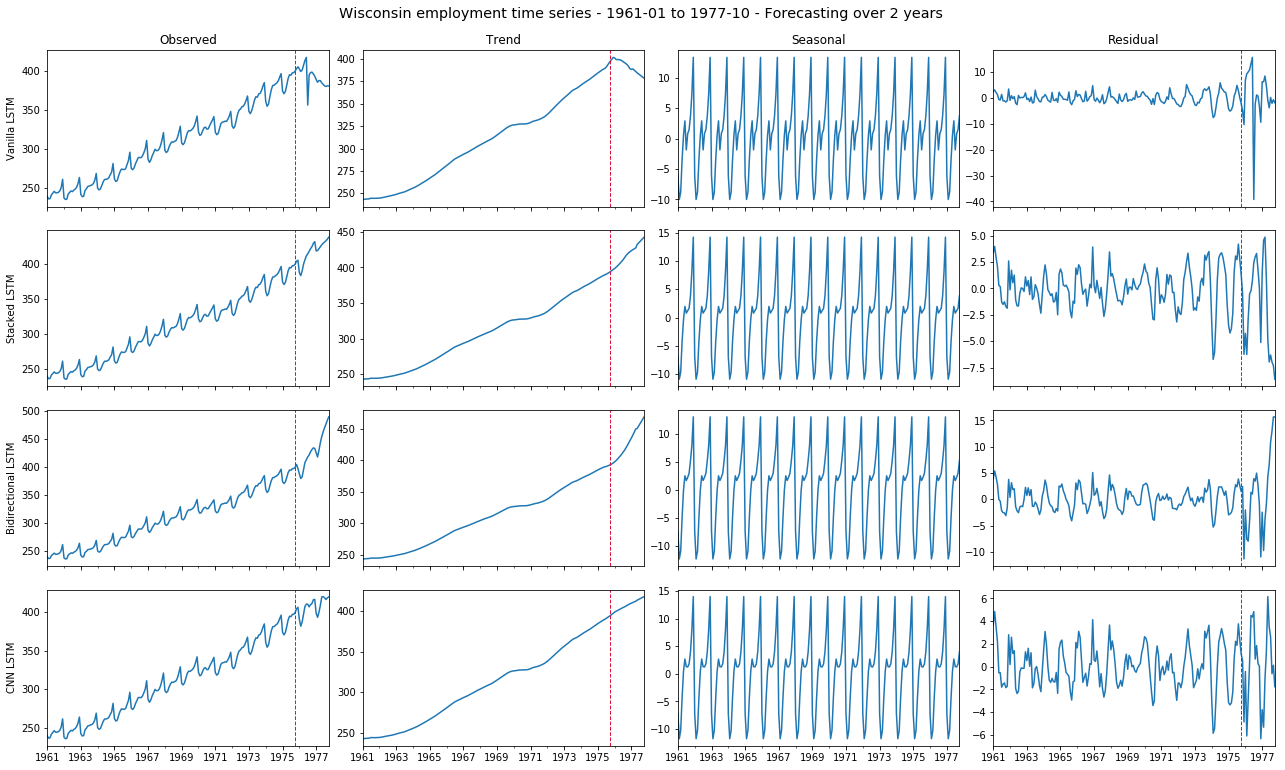

In [84]:
# Plot the result
sub_titles = ['Vanilla LSTM', 'Stacked LSTM', 'Bidirectional LSTM', 'CNN LSTM']
title = 'Wisconsin employment time series - 1961-01 to 1977-10 - Forecasting over 2 years'
fig, ax = plt.subplots(nrows=len(models), ncols=4, sharex=True)
for i in range(len(models)):
    decomposition = seasonal_decompose(df_forecast[col_name[i]], model='additive', extrapolate_trend='freq')
    decomposition.observed.plot(ax=ax[i][0], title='Observed' if i==0 else None)
    ax[i][0].set_ylabel(sub_titles[i])
    ax[i][0].axvline(x='1975-10', linestyle='--', c='crimson', linewidth=1)
    decomposition.trend.plot(ax=ax[i][1], title='Trend' if i==0 else None)
    ax[i][1].axvline(x='1975-10', linestyle='--', c='crimson', linewidth=1)
    decomposition.seasonal.plot(ax=ax[i][2], title='Seasonal' if i==0 else None)
    decomposition.resid.plot(ax=ax[i][3], title='Residual' if i==0 else None)
    ax[i][3].axvline(x='1975-10', linestyle='--', c='crimson', linewidth=1)
fig.suptitle(title, fontsize='x-large')
plt.subplots_adjust(hspace=0.15, wspace=0.12, top=0.93)
plt.gcf().set_size_inches(22, 12)
plt.show()

## 7. Conclusion<a name="conclusion"></a>
By evaluating the four forecasts above, we draw the following conclusions:
- The Vanilla architecture does really bad. Even though it performs well on the test set - even better than CNN by looking at the RMSE - the forecast is not plausible at all. We can see that neither the trend nor the seasonality is respected.
- The Stacked architecture does better than the Vanilla one, but by looking at the forecast, we can see that the trend seems to increase a bit faster than what we would expect. Also the shape of the seasonality is not preserved.
- The same issue applies for the Bidirectionnal architecture. The trend seems to increase even faster than the stacked one while the shape of the seasonality is not preserved.
- Our last architecture - the CNN - seems to perform well. Indeed, we can see that the trend and the shape of the seasonality are preserved.

Even though CNN LSTM is not the model that gave the best scores while tested with a validation set, we can see that it is the one giving the most plausible forecasts. Therefore, we keep its output as final forecasts for our dataset.

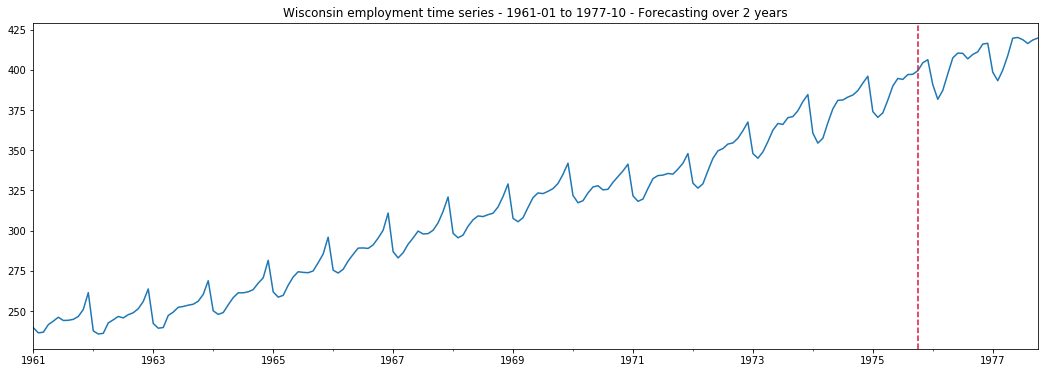

In [83]:
# Plot the forecasted time series
df_forecast['CNN forecast'].plot(colormap='tab10')
plt.title('Wisconsin employment time series - 1961-01 to 1977-10 - Forecasting over 2 years')
plt.axvline(x='1975-10', linestyle='--', c='crimson')
plt.gcf().set_size_inches(18,6)
plt.show()

## 7. References
$[1]$: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ <br>
$[2]$: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ <br>
$[3]$: https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/ <br>
$[4]$: https://www.bioinf.jku.at/publications/older/2604.pdf <br>
$[5]$: https://www.deeplearningbook.org/contents/rnn.html